## Úprava tabulky Nemovitosti

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from shapely.wkt import loads
import numpy as np

### Úprava sloupce State
1. načtení souboru a náhled hlavičky

In [2]:
properties = pd.read_csv('Nemovitosti_upravena - Nemovitosti.csv', encoding='UTF-8')
properties.head(1)

,ID,Name,URL,Item Type,Transaction Type,Ownership,Disposition,Building,Energy Class,Real State,...,Min Ask Price,Max Ask Price,First Ask Price,Delta Ask Price,Days Since Published,Days On Display,Created At,Updated At,Scraped At,Source
0,206888,"Pronájem bytu 1+1 44 m², Antala Staška, Brno, ...",https://www.bezrealitky.cz/nemovitosti-byty-do...,Flat,Rent,Personal Ownership,1+1,Brick,NaN,2.0,...,14 500,14 500,14 500,0,31,4,2023-09-07T03:09:16.686831,2023-09-07T03:09:16.686832,2023-09-07 3:00:01,bezrealitky


2. zobrazení unikátních hodnot

In [3]:
properties['Condition'].unique()

array(['VERY_GOOD', 'BAD', 'NEW', 'GOOD', 'Před rekonstrukcí',
       'Novostavba', 'Velmi dobrý', 'Dobrý', 'Po rekonstrukci', nan,
       'Špatný', 'Ve výstavbě'], dtype=object)

3. nahrazení hodnot ve sloupci State na základě sloupce Real State (použití funkce map)

In [4]:
mapping = {1: 'NEW', 2: 'VERY GOOD', 3: 'GOOD', 4: 'BAD', np.nan: 'UNDEFINED'}

properties['Condition'] = properties['Real State'].map(mapping)
properties['Condition'].unique()


array(['VERY GOOD', 'BAD', 'NEW', 'GOOD', 'UNDEFINED'], dtype=object)

### Vytvoření sloupce City part code v tabulce nemovitostí.
1. načtení souboru s polygony městských částí

In [5]:
city_districts = gpd.read_file('City_districts_boundaries.geojson')
city_districts.head(2)

,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area,geometry
0,1,551066,Brno-Černovice,2023-10-21 00:00:00+00:00,{6EB96659-29DB-403B-B9B2-38354CD970AE},0.120358,0.000776,"MULTIPOLYGON (((16.62823 49.19135, 16.62828 49..."
1,2,551147,Brno-Kohoutovice,2023-10-21 00:00:00+00:00,{2B5B4334-4212-400D-9D56-2F2A708CF06C},0.118019,0.000504,"MULTIPOLYGON (((16.53520 49.20312, 16.53522 49..."


2. vykreslení polygonů pro kontrolu

<Axes: >

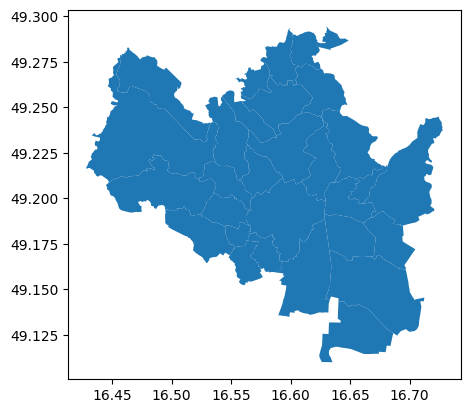

In [6]:
city_districts.plot()

3. vytvoření GeoDataFrame sestávající z lon, lat a point

In [7]:
lat = properties['Lat']
lon = properties['Lon']
df = pd.DataFrame({'lon':lon, 'lat':lat})
df['coords'] = list(zip(df['lon'],df['lat']))
df['coords'] = df['coords'].apply(Point)
points = gpd.GeoDataFrame(df, geometry='coords', crs=city_districts.crs)
points

,lon,lat,coords
0,16.618932,49.212614,POINT (16.61893 49.21261)
1,16.567695,49.171171,POINT (16.56770 49.17117)
2,16.601213,49.217653,POINT (16.60121 49.21765)
3,16.571728,49.247515,POINT (16.57173 49.24751)
4,16.596381,49.179618,POINT (16.59638 49.17962)
...,...,...,...
2189,16.524170,49.222303,POINT (16.52417 49.22230)
2190,16.617080,49.188920,POINT (16.61708 49.18892)
2191,16.647391,49.226867,POINT (16.64739 49.22687)
2192,16.604773,49.228061,POINT (16.60477 49.22806)


4. zkouška vykreslení bodů se zvýrazněním jednoho polygonu

<Axes: >

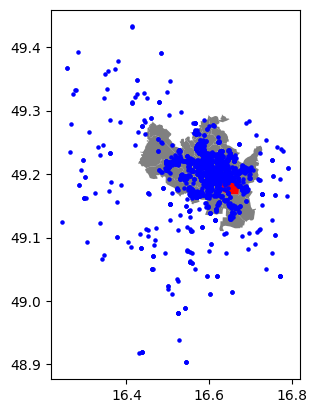

In [8]:
brno_cernovice = city_districts[city_districts.nazev == 'Brno-Černovice']

axes = city_districts.plot(facecolor="grey")
brno_cernovice.plot(ax=axes, facecolor="red")
points.plot(ax=axes, color="blue", markersize=5)

5. provedení spacial joinu = přiřazení bodů do polygonů

In [9]:
pointInPolys = gpd.tools.sjoin(points, city_districts, predicate="within", how='left')
pointInPolys

,lon,lat,coords,index_right,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area
0,16.618932,49.212614,POINT (16.61893 49.21261),15.0,16.0,551031.0,Brno-sever,2023-10-21 00:00:00+00:00,{67B72B6A-CE04-409E-94B5-06A724600FDF},0.322636,0.001512
1,16.567695,49.171171,POINT (16.56770 49.17117),24.0,25.0,551091.0,Brno-Starý Lískovec,2023-10-21 00:00:00+00:00,{0000C47D-2B16-4E33-B502-85921775E38F},0.109633,0.000405
2,16.601213,49.217653,POINT (16.60121 49.21765),5.0,6.0,551007.0,Brno-Královo Pole,2023-10-21 00:00:00+00:00,{69818F01-BA0F-483F-AF3A-80EC25E66A81},0.217828,0.001244
3,16.571728,49.247515,POINT (16.57173 49.24751),12.0,13.0,551244.0,Brno-Řečkovice a Mokrá Hora,2023-10-21 00:00:00+00:00,{2E94E624-9698-4FF7-8A6F-4D1B31837DF0},0.191258,0.000935
4,16.596381,49.179618,POINT (16.59638 49.17962),13.0,14.0,550973.0,Brno-střed,2023-10-21 00:00:00+00:00,{3044A697-15EE-40CF-B775-BF09ED336ACD},0.235792,0.001806
...,...,...,...,...,...,...,...,...,...,...,...
2189,16.524170,49.222303,POINT (16.52417 49.22230),11.0,12.0,551198.0,Brno-Bystrc,2023-10-21 00:00:00+00:00,{62D645F5-93FF-4D87-B43A-8D8B8F2BC1C7},0.455505,0.003366
2190,16.617080,49.188920,POINT (16.61708 49.18892),13.0,14.0,550973.0,Brno-střed,2023-10-21 00:00:00+00:00,{3044A697-15EE-40CF-B775-BF09ED336ACD},0.235792,0.001806
2191,16.647391,49.226867,POINT (16.64739 49.22687),21.0,22.0,551252.0,Brno-Maloměřice a Obřany,2023-10-21 00:00:00+00:00,{82363699-BF66-4BF2-AF17-37891584A49C},0.198097,0.001147
2192,16.604773,49.228061,POINT (16.60477 49.22806),5.0,6.0,551007.0,Brno-Královo Pole,2023-10-21 00:00:00+00:00,{69818F01-BA0F-483F-AF3A-80EC25E66A81},0.217828,0.001244


6. vypsání sloupců pro kontrolu hodnot

In [10]:
pointInPolys[['coords', 'nazev', 'kod']]

,coords,nazev,kod
0,POINT (16.61893 49.21261),Brno-sever,551031.0
1,POINT (16.56770 49.17117),Brno-Starý Lískovec,551091.0
2,POINT (16.60121 49.21765),Brno-Královo Pole,551007.0
3,POINT (16.57173 49.24751),Brno-Řečkovice a Mokrá Hora,551244.0
4,POINT (16.59638 49.17962),Brno-střed,550973.0
...,...,...,...
2189,POINT (16.52417 49.22230),Brno-Bystrc,551198.0
2190,POINT (16.61708 49.18892),Brno-střed,550973.0
2191,POINT (16.64739 49.22687),Brno-Maloměřice a Obřany,551252.0
2192,POINT (16.60477 49.22806),Brno-Královo Pole,551007.0


7. vypsání nulových hodnot

In [11]:
null_values = pointInPolys[pointInPolys['nazev'].isnull()]
null_values

,lon,lat,coords,index_right,ObjectId,kod,nazev,datum_exportu,GlobalID,SHAPE_Length,SHAPE_Area
27,16.348303,49.357965,POINT (16.34830 49.35796),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
29,16.549061,49.079369,POINT (16.54906 49.07937),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
30,16.482846,49.390315,POINT (16.48285 49.39032),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
31,16.297850,49.162472,POINT (16.29785 49.16247),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
72,16.722614,49.190585,POINT (16.72261 49.19058),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2171,16.557922,49.076009,POINT (16.55792 49.07601),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2183,16.727311,49.168629,POINT (16.72731 49.16863),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2185,16.523287,49.111179,POINT (16.52329 49.11118),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN
2186,16.436284,49.083274,POINT (16.43628 49.08327),NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN


8. vykreslení bodů s nulovými hodnotami na mapě

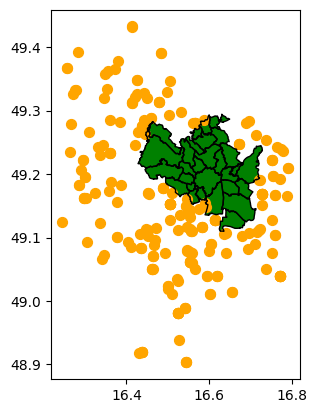

In [12]:
gdf_null = gpd.GeoDataFrame(null_values, geometry='coords')

fig, ax = plt.subplots()
city_districts.boundary.plot(ax=ax, linewidth=1, edgecolor="black")
city_districts.plot(ax=ax, color='green', markersize=50)
gdf_null.plot(ax=ax, color='orange', markersize=50) 
plt.show()

9. vyplnění prázdných hodnot

In [13]:
pointInPolys['nazev'].fillna('Brno-venkov', inplace=True)
pointInPolys['kod'] = pointInPolys['kod'].fillna(550000).astype(int)

10. přiřazení sloupců do tabulky nemovitostí, kontrola počtu (jedna městská část není zastoupena)

In [14]:
properties['coordinates'] = pointInPolys['coords']
properties['City part code'] = pointInPolys['kod']
properties['City part code'].nunique()

29

## Rozdělení hodnot Other ve sloupci Item Type
1. náhled na sloupce Name a Item Type

In [15]:
properties.loc[properties['Item Type'] == 'Other', ['Name', 'Item Type']]

,Name,Item Type
94,Pronájem obchodního prostoru 250 m²,Other
149,"Pronájem kanceláře 23 m², Řípská, Brno, Jihomo...",Other
189,Prodej činžovního domu 282 m²,Other
236,Prodej komerční nemovitosti 150 m²,Other
244,"Pronájem kanceláře 114 m², Renneská třída, Brn...",Other
...,...,...
2178,Prodej kanceláře 386 m²,Other
2182,Pronájem skladového prostoru 46 m²,Other
2188,Pronájem kanceláře 477 m²,Other
2190,Pronájem kanceláře 557 m²,Other


2. převod sloupce na string a nahrazení hodnot Other, kontrola unikátních záznámů

In [16]:
properties['Item Type'] = properties['Item Type'].astype(str)
replacement_dict = {
    'kanceláře': 'Offices',
    'garáže': 'Garage',
    'skladového': 'Warehouse',
    'haly': 'Production hall',
    'obchodního': 'Commercial',
    'garážového': 'Garage parking',
    'restaurace': 'Restaurant',
    'komerční': 'Commercial',
    'činžovního': 'Apartment building'
}

for key, value in replacement_dict.items():
    properties.loc[properties['Name'].str.contains(key, case=False), 'Item Type'] = value

properties['Item Type'].unique()

array(['Flat', 'House', 'Commercial', 'Offices', 'Land',
       'Apartment building', 'Production hall', 'Garage', 'Other',
       'Garage parking', 'Warehouse', 'Restaurant'], dtype=object)

Zápis upraveného souboru.

In [17]:
properties.to_csv('Nemovitosti_v4.tsv', sep='\t', index=False)